In [1]:
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import losses, layers, models, metrics, Model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, metrics
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import torch
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, False)

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
files = []
for i in range(6):
    name =  ''
    if i == 5:
        name = 'cifar-10-batches-py/test_batch'
    else:
        name = 'cifar-10-batches-py/data_batch_' + str(i + 1)
    files.append(unpickle(name))

In [5]:
rotations_num = 4
augment_num = 10

saved_name = 'selfsupervised-r4'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [6]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [7]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [8]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

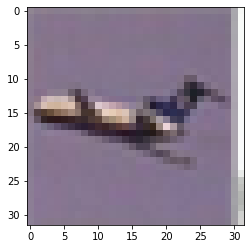

[1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


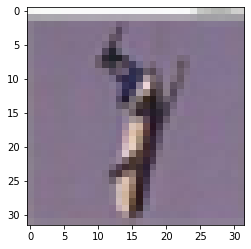

[0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


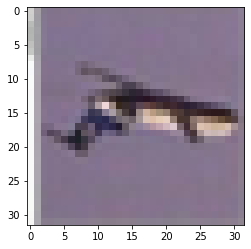

[0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


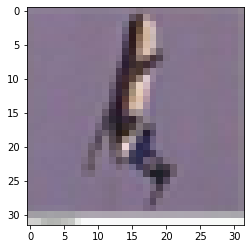

[0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [10]:
#combined_data = preprocess_input(combined_data)

In [11]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
            
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [12]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4, name='out_layer')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(rotations_num, kernel_regularizer=regularizers.l2(l = 0.0001), activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [13]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.get_layer(feature_layer_trained).output
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [14]:
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    
    return lr

In [15]:
def lr_schedule_conv(epoch, lr):
    print(lr)
    if epoch == 80:
        return lr / 5.
    if epoch == 60:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    
    return lr

In [16]:
def lr_schedule_cls(epoch, lr):
    print(lr)
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    if epoch == 10:
        return lr / 5.
    
    return lr

In [17]:
def lr_schedule_linear(epoch, lr):
    print(lr)
    if epoch < supervised_epochs // 2:
        return lr + (0.1 - 0.00001) / supervised_epochs * 2.
    else:
        return max(lr - (0.1 - 0.00001) / supervised_epochs * 2., 0.00001)
    
    return lr

In [18]:
def train_feat():
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name)
    return log

In [19]:
log = train_feat()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Train on 240000 samples
Epoch 1/80
240000/240000 [==============================] - 43s 181us/sample - loss: 2.1446 - accuracy: 0.5872
Epoch 2/80
240000/240000 [==============================] - 39s 162us/sample - loss: 1.5745 - accuracy: 0.6721
Epoch 3/80
240000/240000 [==============================] - 39s 162us/sample - loss: 1.4943 - accuracy: 0.7119
Epoch 4/80
240000/240000 [==============================] - 39s 163us/sample - loss: 1.4213 - accuracy: 0.7383
Epoch 5/80
240000/240000 [==============================] - 39s 161us/sample - loss: 1.3561 - accuracy: 0.7582
Epoch 6/80
240000/240000 [==============================] - 39s 163us/sample - loss: 1.2963 - accuracy: 0.7747
Epoch 7/80
240000/240000 [==============================] - 39s 161us/sample - loss: 1.2406 - accuracy: 0.7870
Epoch 8/80
240000/240000 [==============================] - 38s 160us/sample - loss: 1.1910 - accuracy: 0.7979
Epoch 9/80
240000/240000 [==============================] - 39s 161us/sample - loss: 1.1

240000/240000 [==============================] - 38s 160us/sample - loss: 0.1041 - accuracy: 0.9768
Epoch 75/80
240000/240000 [==============================] - 39s 162us/sample - loss: 0.1026 - accuracy: 0.9777
Epoch 76/80
240000/240000 [==============================] - 39s 163us/sample - loss: 0.1036 - accuracy: 0.9772
Epoch 77/80
240000/240000 [==============================] - 39s 163us/sample - loss: 0.1021 - accuracy: 0.9776
Epoch 78/80
240000/240000 [==============================] - 39s 162us/sample - loss: 0.0999 - accuracy: 0.9784
Epoch 79/80
240000/240000 [==============================] - 39s 161us/sample - loss: 0.1011 - accuracy: 0.9777
Epoch 80/80
240000/240000 [==============================] - 39s 162us/sample - loss: 0.1013 - accuracy: 0.9776
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: selfsupervised-r4/assets


In [20]:
def get_cls_model(name = saved_name, use_features = True, percent = 100):
    if use_features:
        model = tf.keras.models.load_model(name)
    else:
        model = tf.keras.models.load_model('emptyResNet')
        
    if percent >= 50:
        l = model.get_layer(feature_layer).output
    else:
        l = model.get_layer(first_resnet_layer).output
        
    #model = tf.keras.models.load_model(cnn_name)
    #l = model.get_layer(feature_layer_cnn).output
    
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [21]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
            
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [22]:
cls_train_features = train_cls(True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 228us/sample - loss: 4.3619 - accuracy: 0.4125 - val_loss: 3.2867 - val_accuracy: 0.5314
Epoch 2/50
50000/50000 [==============================] - 9s 178us/sample - loss: 3.0649 - accuracy: 0.5575 - val_loss: 3.0005 - val_accuracy: 0.5400
Epoch 3/50
50000/50000 [==============================] - 8s 169us/sample - loss: 2.7558 - accuracy: 0.5966 - val_loss: 2.7250 - val_accuracy: 0.5891
Epoch 4/50
50000/50000 [==============================] - 9s 183us/sample - loss: 2.5673 - accuracy: 0.6340 - val_loss: 2.8449 - val_accuracy: 0.5426
Epoch 5/50
50000/50000 [==============================] - 9s 173us/sample - loss: 2.4603 - accuracy: 0.6583 - val_loss: 2.6405 - val_accuracy: 0.5907
Epoch 6/50
50000/50000 [==============================] - 9s 171us/sample - loss: 2.3916 - accuracy: 0.6758 - val_loss: 2.5416 - val_accuracy: 0.6362
Epoch 7/50
50000/50000 [=========================

In [23]:
cls_no_train_features = train_cls(False)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 147us/sample - loss: 6.3386 - accuracy: 0.1198 - val_loss: 5.9887 - val_accuracy: 0.1854
Epoch 2/50
50000/50000 [==============================] - 5s 110us/sample - loss: 5.9578 - accuracy: 0.1464 - val_loss: 5.8485 - val_accuracy: 0.1425
Epoch 3/50
50000/50000 [==============================] - 5s 110us/sample - loss: 5.8018 - accuracy: 0.1565 - val_loss: 5.7548 - val_accuracy: 0.1254
Epoch 4/50
50000/50000 [==============================] - 6s 111us/sample - loss: 5.7231 - accuracy: 0.1613 - val_loss: 5.7099 - val_accuracy: 0.1241
Epoch 5/50
50000/50000 [==============================] - 6s 110us/sample - loss: 5.6848 - accuracy: 0.1658 - val_loss: 5.6919 - val_accuracy: 0.1181
Epoch 6/50
50000/50000 [==============================] - 6s 111us/sample - loss: 5.6668 - accuracy: 0.1683 - val_loss: 5.6726 - val_accuracy: 0.1244
Epoch 7/50
50000/50000 [==========================

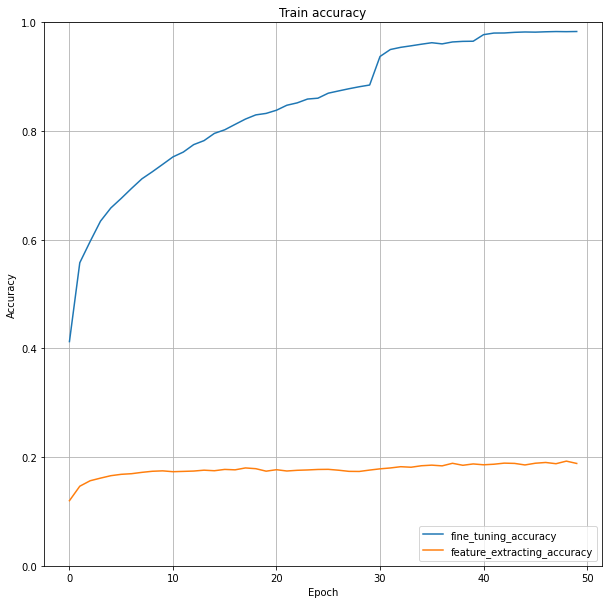

In [24]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

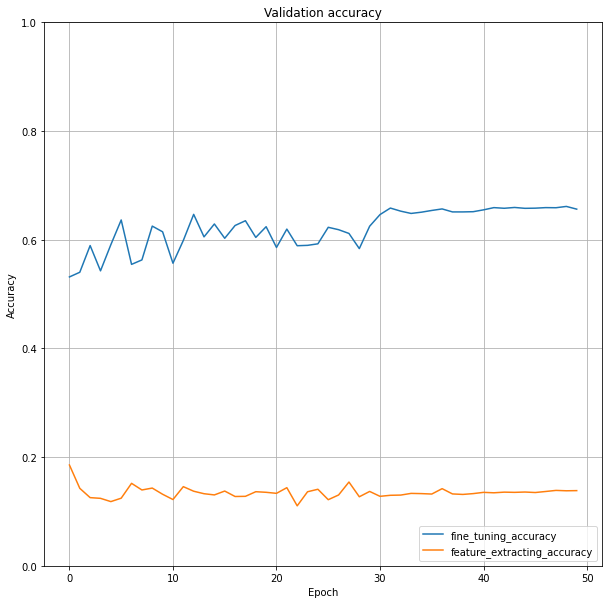

In [25]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 2

In [28]:
rotations_num = 2
augment_num = 10

saved_name = 'selfsupervised-r2'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [29]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [30]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [31]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

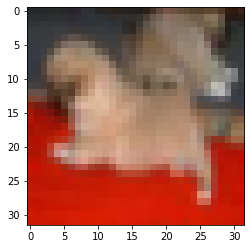

[1. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


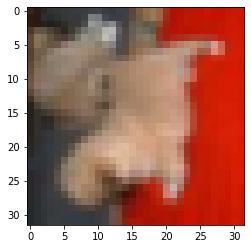

[0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [32]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [33]:
#combined_data = preprocess_input(combined_data)

In [34]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
            
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [35]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4, name='out_layer')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(rotations_num, kernel_regularizer=regularizers.l2(l = 0.0001), activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [36]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.get_layer(feature_layer_trained).output
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [37]:
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    
    return lr

In [38]:
def lr_schedule_conv(epoch, lr):
    print(lr)
    if epoch == 80:
        return lr / 5.
    if epoch == 60:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    
    return lr

In [39]:
def lr_schedule_cls(epoch, lr):
    print(lr)
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    if epoch == 10:
        return lr / 5.
    
    return lr

In [40]:
def lr_schedule_linear(epoch, lr):
    print(lr)
    if epoch < supervised_epochs // 2:
        return lr + (0.1 - 0.00001) / supervised_epochs * 2.
    else:
        return max(lr - (0.1 - 0.00001) / supervised_epochs * 2., 0.00001)
    
    return lr

In [41]:
def train_feat():
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name)
    return log

In [42]:
log = train_feat()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 120000 samples
Epoch 1/80
120000/120000 [==============================] - 23s 189us/sample - loss: 1.5946 - accuracy: 0.7619
Epoch 2/80
120000/120000 [==============================] - 19s 159us/sample - loss: 0.9092 - accuracy: 0.8220
Epoch 3/80
120000/120000 [==============================] - 20s 169us/sample - loss: 0.8288 - accuracy: 0.8504
Epoch 4/80
120000/120000 [==============================] - 20s 165us/sample - loss: 0.7879 - accuracy: 0.8645
Epoch 5/80
120000/120000 [==============================] - 21s 174us/sample - loss: 0.7582 - accuracy: 0.8768
Epoch 6/80
120000/120000 [==============================] - 20s 170us/sample - loss: 0.7281 - accuracy: 0.8882
Epoch 7/80
120000/120000 [==============================] - 21s 173us/sample - loss: 0.7022 - accuracy: 0.8953
Epoch 8/80
120000/120000 [==============================] - 20s 165us/sample - loss: 0.6770 - accuracy: 0.9012
Epoch 9/80
120000/120000 [==============================] - 20s 168us/sample - loss: 0.6

120000/120000 [==============================] - 20s 169us/sample - loss: 0.0086 - accuracy: 0.9995
Epoch 75/80
120000/120000 [==============================] - 20s 164us/sample - loss: 0.0086 - accuracy: 0.9995
Epoch 76/80
120000/120000 [==============================] - 20s 164us/sample - loss: 0.0078 - accuracy: 0.9996
Epoch 77/80
120000/120000 [==============================] - 20s 165us/sample - loss: 0.0082 - accuracy: 0.9995
Epoch 78/80
120000/120000 [==============================] - 20s 165us/sample - loss: 0.0082 - accuracy: 0.9995
Epoch 79/80
120000/120000 [==============================] - 20s 168us/sample - loss: 0.0081 - accuracy: 0.9996
Epoch 80/80
120000/120000 [==============================] - 20s 169us/sample - loss: 0.0076 - accuracy: 0.9997
INFO:tensorflow:Assets written to: selfsupervised-r2/assets


In [43]:
def get_cls_model(name = saved_name, use_features = True, percent = 100):
    if use_features:
        model = tf.keras.models.load_model(name)
    else:
        model = tf.keras.models.load_model('emptyResNet')
        
    if percent >= 50:
        l = model.get_layer(feature_layer).output
    else:
        l = model.get_layer(first_resnet_layer).output
        
    #model = tf.keras.models.load_model(cnn_name)
    #l = model.get_layer(feature_layer_cnn).output
    
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [44]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
            
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [45]:
cls_train_features = train_cls(True)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 240us/sample - loss: 4.2188 - accuracy: 0.4319 - val_loss: 3.2887 - val_accuracy: 0.5335
Epoch 2/50
50000/50000 [==============================] - 9s 187us/sample - loss: 2.9604 - accuracy: 0.5794 - val_loss: 2.8813 - val_accuracy: 0.5690
Epoch 3/50
50000/50000 [==============================] - 9s 171us/sample - loss: 2.6559 - accuracy: 0.6253 - val_loss: 2.7041 - val_accuracy: 0.6035
Epoch 4/50
50000/50000 [==============================] - 9s 187us/sample - loss: 2.4892 - accuracy: 0.6571 - val_loss: 2.9372 - val_accuracy: 0.5483
Epoch 5/50
50000/50000 [==============================] - 9s 175us/sample - loss: 2.3845 - accuracy: 0.6820 - val_loss: 2.5998 - val_accuracy: 0.6133
Epoch 6/50
50000/50000 [==============================] - 9s 182us/sample - loss: 2.3013 - accuracy: 0.7036 - val_loss: 2.5577 - val_accuracy: 0.6148
Epoch 7/50
50000/50000 [=========================

In [ ]:
cls_no_train_features = train_cls(False)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 151us/sample - loss: 6.3153 - accuracy: 0.1200 - val_loss: 5.9591 - val_accuracy: 0.2168
Epoch 2/50
50000/50000 [==============================] - 5s 109us/sample - loss: 5.9388 - accuracy: 0.1467 - val_loss: 5.7944 - val_accuracy: 0.2236
Epoch 3/50
50000/50000 [==============================] - 6s 114us/sample - loss: 5.7829 - accuracy: 0.1557 - val_loss: 5.6897 - val_accuracy: 0.2147
Epoch 4/50
50000/50000 [==============================] - 6s 114us/sample - loss: 5.7019 - accuracy: 0.1637 - val_loss: 5.6446 - val_accuracy: 0.1915
Epoch 5/50
50000/50000 [==============================] - 6s 115us/sample - loss: 5.6669 - accuracy: 0.1694 - val_loss: 5.6211 - val_accuracy: 0.1963
Epoch 6/50
50000/50000 [==============================] - 6s 113us/sample - loss: 5.6472 - accuracy: 0.1714 - val_loss: 5.6135 - val_accuracy: 0.1954
Epoch 7/50
50000/50000 [==========================

In [ ]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])

# Rotations - 8

In [ ]:
rotations_num = 8
augment_num = 10

saved_name = 'selfsupervised-r8'
cnn_name = 'mycnn'

selfsupervised_epochs = 80
selfsupervised_batch_size = 128
supervised_epochs = 50
supervised_batch_size = 128
supervised_trainval_ratio = 1. / 6 #1/6 is implied in CIFAR-10

feature_layer_trained = 'conv2_block3_out'
feature_layer = 'conv2_block3_out'
first_resnet_layer = 'conv2_block1_out'
second_resnet_layer = 'conv2_block2_out'
feature_layer_cnn = 'out_layer'

In [ ]:
combined_data = np.zeros((60000 * rotations_num, 32, 32, 3), dtype = np.float32)
combined_labels = np.zeros((60000 * rotations_num, rotations_num), dtype = np.float32)

In [ ]:
true_labels = np.zeros((60000 * rotations_num, 10), dtype = np.float32)

In [ ]:
for i in range(len(files)):
    data_len = files[i][b"data"].shape[0]
    
    for j in range(data_len):
        row = files[i][b"data"][j]
        true_labels[rotations_num * (data_len * i + j)][files[i][b"labels"][j]] = 1.
        
        for k in range(files[i][b"data"].shape[1]):
            combined_data[rotations_num * (data_len * i + j)][(k & 1023) >> 5][k & 31][k >> 10] = row[k]
        combined_labels[rotations_num * (data_len * i + j)][0] = 1.
        
        for t in range(1, rotations_num):
            true_labels[rotations_num * (data_len * i + j) + t][files[i][b"labels"][j]] = 1.
            combined_data[rotations_num * (data_len * i + j) + t] = np.rot90(combined_data[rotations_num * (data_len * i + j)], t)
            combined_labels[rotations_num * (data_len * i + j) + t][t] = 1.

In [ ]:
r = random.randint(0, 60000)

for i in range(rotations_num):
    plt.imshow(combined_data[r * rotations_num + i].astype(int))
    plt.show()
    print(combined_labels[r * rotations_num + i])
    print(true_labels[r * rotations_num + i])

In [ ]:
#combined_data = preprocess_input(combined_data)

In [ ]:
def plot_training(**kwargs):
    plt.figure(figsize = (10, 10))
    
    for k, v in kwargs.items():
        if k != 'name' and k != 'filename':
            plt.plot(v, label=k)
            
    plt.grid(True)
    if 'name' in kwargs:
        plt.title(kwargs['name'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    if 'filename' in kwargs:
        plt.savefig(kwargs['filename'])

In [ ]:
def get_feat_model():
    inputs = tf.keras.Input((32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4, name='out_layer')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(200, kernel_regularizer=regularizers.l2(l = 0.0001), kernel_initializer='he_uniform')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(rotations_num, kernel_regularizer=regularizers.l2(l = 0.0001), activation = 'softmax')(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [ ]:
def get_conv_model():
    base = ResNet50(include_top=False, weights=None, input_shape=(32, 32, 3))
    l = base.get_layer(feature_layer_trained).output
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(rotations_num, kernel_regularizer=regularizers.l1_l2(l1 = 0.00005, l2 = 0.0001), activation = 'softmax')(l)
    
    return tf.keras.Model(inputs = base.input, outputs = l)

In [ ]:
def lr_schedule(epoch, lr):
    if epoch == 50:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    
    return lr

In [ ]:
def lr_schedule_conv(epoch, lr):
    print(lr)
    if epoch == 80:
        return lr / 5.
    if epoch == 60:
        return lr / 5.
    if epoch == 40:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    
    return lr

In [ ]:
def lr_schedule_cls(epoch, lr):
    print(lr)
    if epoch == 40:
        return lr / 5.
    if epoch == 30:
        return lr / 5.
    if epoch == 20:
        return lr / 5.
    if epoch == 10:
        return lr / 5.
    
    return lr

In [ ]:
def lr_schedule_linear(epoch, lr):
    print(lr)
    if epoch < supervised_epochs // 2:
        return lr + (0.1 - 0.00001) / supervised_epochs * 2.
    else:
        return max(lr - (0.1 - 0.00001) / supervised_epochs * 2., 0.00001)
    
    return lr

In [ ]:
def train_feat():
    model = get_conv_model()
    model.summary()
    model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    log = model.fit(combined_data, combined_labels, 
                    epochs = selfsupervised_epochs, batch_size = selfsupervised_batch_size, 
                    shuffle = True, callbacks = [LearningRateScheduler(lr_schedule)])
    model.save(saved_name)
    return log

In [ ]:
log = train_feat()

In [ ]:
def get_cls_model(name = saved_name, use_features = True, percent = 100):
    if use_features:
        model = tf.keras.models.load_model(name)
    else:
        model = tf.keras.models.load_model('emptyResNet')
        
    if percent >= 50:
        l = model.get_layer(feature_layer).output
    else:
        l = model.get_layer(first_resnet_layer).output
        
    #model = tf.keras.models.load_model(cnn_name)
    #l = model.get_layer(feature_layer_cnn).output
    
    l = layers.Flatten()(l)
    l = layers.BatchNormalization()(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(200, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), kernel_initializer='he_uniform')(l)
    l = layers.BatchNormalization()(l)
    l = layers.Activation('relu')(l)
    l = layers.Dropout(0.5)(l)
    l = layers.Dense(10, kernel_regularizer=regularizers.l1_l2(l1 = 0.0001, l2 = 0.0005), activation = 'softmax')(l)
    return tf.keras.Model(inputs = model.input, outputs = l)

In [ ]:
def train_cls(train_features = True):
    cls_model = get_cls_model()
    cls_model.summary()
    
    if not train_features:
        for l in cls_model.layers[:-5]:
            l.trainable = False
            
    cls_model.compile(optimizer = optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])
    cls_log = cls_model.fit(combined_data[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            true_labels[:int(60000 * (1.0 - supervised_trainval_ratio))], 
                            epochs = supervised_epochs, batch_size = supervised_batch_size, shuffle = True,
                            callbacks = [LearningRateScheduler(lr_schedule)],
                            validation_data = (combined_data[int(60000 * (1.0 - supervised_trainval_ratio)):60000], 
                                               true_labels[int(60000 * (1.0 - supervised_trainval_ratio)):60000]))
    return cls_log

In [ ]:
cls_train_features = train_cls(True)

In [ ]:
cls_no_train_features = train_cls(False)

In [ ]:
plot_training(name = 'Train accuracy',
              fine_tuning_accuracy = cls_train_features.history['accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['accuracy'])

In [ ]:
plot_training(name = 'Validation accuracy',
              fine_tuning_accuracy = cls_train_features.history['val_accuracy'],
              feature_extracting_accuracy = cls_no_train_features.history['val_accuracy'])